Objective:
My objevtive for the machine learning project is to create a Recurrent Neural Network (RNN) that can generate (somewhat) legible poetry based on a collection of poems with a GAN external network to optimize the RNN potential. To do so, I will take a kaggle dataset with 500+ poems written from the reniassance and modern era of poetry to be used as the 'real' data for the discriminator.

Tools:
Libraries include pandas, numpy, keras.preprocessing for tokenizer (discussed below), GloVe dictionary (below), and keras.layers/models and the like for neural network model architecture and execution. 

Various hygiene methods are required to standardize each poem into the same length, as well as adding padding for poems less in length. Instead of feeding in actual words, I will encode each word into a tokenizer, so integers are fed into the network rather than words. Further, to better contend with writing legible poetry, I use feature engineering from https://nlp.stanford.edu/projects/glove/ to encode words to higher dimensional space. Words with similar meaning should have a similar vector space, for example. 

Both the generator and discriminator have RNN structures, including one LSTM layer to predict the next word based on the series of words prior in sequence. The discriminator will take samples from our real poems and full generated poems to try and classify real from fake. 


link to data : https://www.kaggle.com/ishnoor/poetry-analysis-with-machine-learning

References: some hygiene steps came from https://www.kaggle.com/hsankesara/mr-poet and some GAN framework coding came from https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.5-introduction-to-gans.ipynb

In [1]:
import pandas as pd
import numpy as np

poems = pd.read_csv("all.csv")

#### Adding character length column

In [2]:
poems['length'] = 0
for i in range(len(poems)):
    poems['length'][i] = len(poems['content'][i])

/Users/samburtch/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Clean data by deleting null entries and non-poems

In [3]:
poems = poems.sort_values(by='length') #Sort by length of poem
poems = poems[14:len(poems)-5] # Delete tails on both sides
poems = poems[poems['content'].str.contains('Published')==False]# Eliminate non-poems with 'Published'
print(len(poems))
poems = poems[poems['content'].str.contains('from Selected Poems')==False]# Eliminate non-poems with 'from Selected Poems'
print(len(poems))
poems = poems[poems['content'].str.contains('Collected Poems')==False]# Eliminate non-poems with 'from Collected Poems'
print(len(poems))
#Eliminate where poem is just intro
for ind, row in poems.iterrows():
    if row['author'] in row['content'].upper() or str(row['poem name']) in row['content'][:40]:
        poems = poems.drop([ind])
print(len(poems))

552
536
518
465


### Hygiene: only poems between 100 & 1000 in character length

In [4]:
num_poems = len(poems)
poem = poems['content'][:num_poems]
poem = poem[poems['length'] > 100]
poem = poem[poems['length'] < 1000]
poem = poem.reset_index(drop=True)
X = poem
num_poems = len(poem)

### Create vocab size and word dictionary

In [5]:
temp = ''
for i in range(num_poems):
    temp += poem[i] + ' '
poem = temp

import re
#poem = re.sub(' +',' ',poem)
poem = poem.lower()
poem = re.findall(r'[\w]+|[\'!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]',poem)
words = list(set(poem))
vocab_size = len(words)
#print(vocab_size)


In [6]:
print(X.describe())

count                                                   349
unique                                                  311
top       When I was fair and young, then favor graced m...
freq                                                      3
Name: content, dtype: object


In [7]:
X[0]

'The fog comes\r\non little cat feet.\r\n\r\nIt sits looking\r\nover harbor and city\r\non silent haunches\r\nand then moves on.'

In [8]:
for i in range(len(X)):
    X[i] = X[i].replace("\r\n"," ")  

### Feature Engineering: Convert words to integers (tokenizer)  

In [9]:
from keras.preprocessing.text import  Tokenizer
from keras.preprocessing.sequence import pad_sequences

/Users/samburtch/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
tokenizer = Tokenizer( num_words=vocab_size)

In [11]:
tokenizer.fit_on_texts(X)

In [12]:
text = tokenizer.texts_to_sequences(X)
maxlen = 0
for i in text:
    if len(i) > maxlen:
        maxlen = len(i)
text = pad_sequences(text, maxlen=maxlen, padding='post')

In [13]:
word_dict = tokenizer.word_index

In [14]:
maxwords = len(word_dict)

### Map words to 50-dim vector (embedding_matrix)

In [15]:
embedding_matrix = np.zeros((maxwords+1,50))

In [16]:
with open('glove.6B.50d.txt') as f:
    for line in f:
        l = line.split()
        if l[0] in word_dict:
            indx = word_dict[l[0]]
            for i in range(50):
                embedding_matrix[indx][i] = l[i+1]

### Create 349 x 177 x 50 X_train matrix

In [17]:
x_train = np.zeros((349,177,50),dtype='float32')
for indp, poem in enumerate(text):
    for indw, word in enumerate(poem):
        x_train[indp,indw,:] = embedding_matrix[word]

## Network 
<img src="gan.png">
GAN networks are two separate networks playing against each other. The Generator gets random noise and creates output, attempting to try and fool the discriminator into thinking the generated output is real data, poems in our case. The discriminators only job is to decide if the input was real or fake.

In [18]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Input
from keras.optimizers import RMSprop


num_steps = 177
#hidden_size = 350
feature_dim = 50

### Generator

In [19]:
generator_input = Input(shape=(num_steps,1))

x = LSTM(feature_dim, return_sequences=True, recurrent_dropout=0.2)(generator_input)
x = LSTM(feature_dim, return_sequences=True, recurrent_dropout=0.2)(x)
generator = Model(generator_input, x)

### Discriminator

In [20]:
discriminator_input = Input(shape=(num_steps,feature_dim))

x = LSTM(feature_dim, return_sequences=True, recurrent_dropout=0.2)(discriminator_input) #return_sequences=True,
x = LSTM(feature_dim, recurrent_dropout=0.2)(x)
x = Dense(1, activation='sigmoid')(x)

discriminator = Model(discriminator_input, x)

discriminator_optimizer = RMSprop(lr=0.0001, clipvalue=1.0) #decay=1e-8
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

### GAN Framework

In [21]:
from keras import backend

# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = Input(shape=(num_steps,1))
gen_output = generator(gan_input)
gan_output = discriminator(gen_output)
gan = Model(gan_input, gan_output)

gan_optimizer = RMSprop(lr=0.001, clipvalue=1.0) #decay=1e-8
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

### Training Steps

In [22]:
iterations = 10000
batch_size = 5

# Start training loop
start = 0
# Track Losses
d_losses = []
g_losses = []
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size,num_steps, 1))

    # Decode them to fake poems
    generated_poems = generator.predict(random_latent_vectors)

    # Combine them with real poems
    stop = start + batch_size
    real_poems = x_train[start: stop]
    combined_poems = np.concatenate([generated_poems, real_poems])

    # Assemble labels discriminating real from fake poems
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_poems, labels)
    d_losses.append(d_loss)
    
    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size*2, num_steps, 1))

    # Assemble labels that say "all real poems"
    misleading_targets = np.zeros((batch_size*2, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    g_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    g_losses.append(g_loss)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    
    if step % 10 == 0:
        # Save model weights
        #gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('generator loss at step %s: %s' % (step, g_loss))
        

/Users/samburtch/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.6920873
generator loss at step 0: 0.6966387
discriminator loss at step 10: 0.8458086
generator loss at step 10: 0.48831588
discriminator loss at step 20: 0.84898806
generator loss at step 20: 0.47552508
discriminator loss at step 30: 0.80207574
generator loss at step 30: 0.5421148
discriminator loss at step 40: 0.7531474
generator loss at step 40: 0.60654247
discriminator loss at step 50: 0.74729776
generator loss at step 50: 0.6333684
discriminator loss at step 60: 0.7485031
generator loss at step 60: 0.60230625
discriminator loss at step 70: 0.78724843
generator loss at step 70: 0.56337565
discriminator loss at step 80: 0.77708435
generator loss at step 80: 0.5739377
discriminator loss at step 90: 0.7511819
generator loss at step 90: 0.62389386
discriminator loss at step 100: 0.6987225
generator loss at step 100: 0.6850028
discriminator loss at step 110: 0.6954695
generator loss at step 110: 0.7050105
discriminator loss at step 120: 0.7308098
generator

discriminator loss at step 1020: 0.6948181
generator loss at step 1020: 0.7397195
discriminator loss at step 1030: 0.688212
generator loss at step 1030: 0.743137
discriminator loss at step 1040: 0.6941956
generator loss at step 1040: 0.74120843
discriminator loss at step 1050: 0.690996
generator loss at step 1050: 0.73967105
discriminator loss at step 1060: 0.6939238
generator loss at step 1060: 0.737608
discriminator loss at step 1070: 0.6950324
generator loss at step 1070: 0.7433268
discriminator loss at step 1080: 0.6946225
generator loss at step 1080: 0.74216473
discriminator loss at step 1090: 0.6896813
generator loss at step 1090: 0.7444212
discriminator loss at step 1100: 0.6792675
generator loss at step 1100: 0.7422532
discriminator loss at step 1110: 0.6973547
generator loss at step 1110: 0.74047697
discriminator loss at step 1120: 0.69042313
generator loss at step 1120: 0.7405403
discriminator loss at step 1130: 0.6918121
generator loss at step 1130: 0.7438568
discriminator l

discriminator loss at step 2020: 0.6874932
generator loss at step 2020: 0.77688
discriminator loss at step 2030: 0.6798018
generator loss at step 2030: 0.75800496
discriminator loss at step 2040: 0.68550575
generator loss at step 2040: 0.6903578
discriminator loss at step 2050: 0.6747263
generator loss at step 2050: 0.739214
discriminator loss at step 2060: 0.59056807
generator loss at step 2060: 0.7082219
discriminator loss at step 2070: 0.6991123
generator loss at step 2070: 0.80188596
discriminator loss at step 2080: 0.68884313
generator loss at step 2080: 0.6976617
discriminator loss at step 2090: 0.63442373
generator loss at step 2090: 0.72825515
discriminator loss at step 2100: 0.6174053
generator loss at step 2100: 0.74101025
discriminator loss at step 2110: 0.61280566
generator loss at step 2110: 0.78452957
discriminator loss at step 2120: 0.67774886
generator loss at step 2120: 0.73418844
discriminator loss at step 2130: 0.5854166
generator loss at step 2130: 0.85847247
discri

KeyboardInterrupt: 

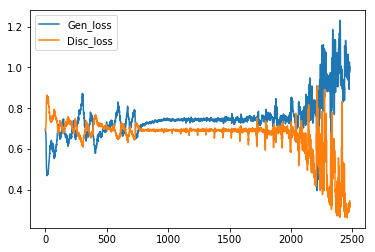

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(g_losses)
plt.plot(d_losses)
plt.legend(['Gen_loss','Disc_loss'])

In [24]:
random_latent_vector = np.random.normal(size=(1,num_steps, 1))

# Decode them to fake poems
generated_poem = generator.predict(random_latent_vector)

In [25]:
generated_poem.reshape(177,50)

array([[ 4.8575358e-04, -1.9415155e-02, -3.2703218e-03, ...,
        -1.4718541e-02, -2.1906139e-03, -1.6929712e-02],
       [ 3.8789891e-04, -2.2236668e-02,  2.3301807e-03, ...,
        -2.1957772e-02,  1.4581555e-03, -6.8360684e-03],
       [ 1.9202994e-03, -2.7034620e-02,  4.6427529e-03, ...,
        -2.9199930e-02,  8.1297792e-03, -4.8007676e-03],
       ...,
       [ 6.3493466e-01,  5.6074250e-01,  1.8630058e-01, ...,
         5.2177477e-01, -3.7874365e-01, -8.1796139e-01],
       [ 6.3131809e-01,  5.6201589e-01,  1.8792439e-01, ...,
         5.2780575e-01, -3.7630427e-01, -8.1706989e-01],
       [ 6.3339984e-01,  5.6165701e-01,  1.9029759e-01, ...,
         5.2543670e-01, -3.7873662e-01, -8.1751895e-01]], dtype=float32)

In [26]:
import math
poem = []
dists = []
for word in generated_poem[0]:
    num = 0
    dist = math.inf
    for ind, vec in enumerate(embedding_matrix[1:]):
        temp = np.linalg.norm(vec-word)
        if temp < dist:
            dist = temp
            num = ind
    if num != 0:
        poem.append(tokenizer.index_word[num])
    else:
        poem.append(' ')
    dists.append(dist)

The eucliean distance at each step apears to gradually increase, suggesting that the network was fairly decent at the earlier stages of the poem but got increasingly more difficult to predict the next word as the poem progressed. 

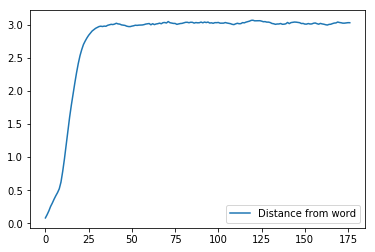

In [27]:
plt.plot(dists)
plt.legend(['Distance from word'])

In [28]:
print(poem)

['shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 'shame', 